
# Optimización de Vigilancia Autónoma mediante *Orienteering Problem* (OP)
**Caso de Estudio:** Sector Apepú - Arroyo Yacu-í, Parque Nacional Iguazú, Argentina.

---

## 1. El Escenario Táctico
El **Sector Apepú** es una de las zonas más biodiversas y vulnerables del Parque Nacional Iguazú. Su proximidad a la **Ruta Nacional 101** facilita la infiltración de cazadores furtivos, quienes ingresan al monte para establecer "saleros" (cebaderos) y campamentos ilegales cerca del **Arroyo Yacu-í**.

### El Problema de la "Manta Corta"
Contamos con drones de vigilancia, pero enfrentamos tres restricciones críticas:
1. **Autonomía Limitada:** Solo 40 minutos de batería por misión.
2. **Geografía Hostil:** La selva virgen impide la recuperación de equipos en caso de aterrizajes forzosos fuera de senderos.
3. **Incertidumbre:** No podemos patrullar todo el parque. Debemos elegir los puntos de mayor probabilidad de detección.

## 2. Objetivo de este Notebook: Análisis de Factibilidad
Antes de implementar un sistema de inteligencia artificial, es imperativo validar si las estrategias tradicionales de patrullaje son viables bajo las restricciones físicas del entorno. 
notebook es:
1. **Digitalizar el Terreno:** Traducir la geografía del Sector Apepú a una estructura de grafos y matrices de costos reales.
2. **Establecer el Baseline:** Calcular la ruta de cobertura total (**Traveling Salesperson Problem**) para determinar si es posible visitar todos los nodos con la tecnología actual.
3. **Identificar el "Gap" Operativo:** Cuantificar la diferencia entre la autonomía de la batería y el tiempo requerido para una misión completa, justificando así la necesidad de modelos de optimización avanzada.

## 3. Modelado: Definición de Nodos

Para modelar el problema, definimos un grafo donde los nodos representan puntos estratégicos. Hemos seleccionado **10 nodos reales** basados en cartografía oficial e inteligencia táctica:
* **Bases:** Puntos de inicio y fin (Seccionales Apepú y Yacu-í).
* **Accesos:** Cruces en la RN101 donde se detecta el ingreso vehicular.
* **Hotspots:** Puntos de alta prioridad biológica (Saleros y desembocaduras).
* **Sensores:** Ubicaciones de cámaras trampa instaladas en el monte.

### 3.1. Definición de la Red de Vigilancia
Para modelar el problema, digitalizamos el sector en 10 nodos estratégicos. Cada punto posee un **Surveillance Score ($S_i$)**: un valor adimensional que cuantifica la importancia biológica y el riesgo de intrusión. Aunque este valor no afecta la distancia física, será el motor de decisión en nuestra futura optimización.

In [16]:
import pandas as pd

# Definición consolidada de la Red de Vigilancia (10 Nodos Reales)
nodos_data = [
    {"id": 0, "tag": "BASE", "nombre": "Seccional Apepú", "lat": -25.56347, "lon": -54.29574, "score": 0},
    {"id": 1, "tag": "BASE", "nombre": "Seccional Yacu-í", "lat": -25.680885, "lon": -54.162300, "score": 0},
    {"id": 2, "tag": "ACCESO", "nombre": "Control 101 Central", "lat": -25.677424, "lon": -54.227024, "score": 40},
    {"id": 3, "tag": "OBJETIVO", "nombre": "Desembocadura A. León", "lat": -25.587602, "lon": -54.230119, "score": 85},
    {"id": 4, "tag": "OBJETIVO", "nombre": "Salero Selva Central", "lat": -25.62573, "lon": -54.28597, "score": 95},
    {"id": 5, "tag": "OBJETIVO", "nombre": "Desembocadura A. Yacuy", "lat": -25.587192, "lon": -54.181625, "score": 90},
    {"id": 6, "tag": "ACCESO", "nombre": "Intersección Picada", "lat": -25.67426, "lon": -54.28429, "score": 25},
    {"id": 7, "tag": "TRANSITO", "nombre": "Punto Avistaje 300m", "lat": -25.65665, "lon": -54.21073, "score": 70},
    {"id": 8, "tag": "ACCESO", "nombre": "Vadeo A. Sto. Domingo", "lat": -25.67329, "lon": -54.26972, "score": 30},
    {"id": 9, "tag": "OBJETIVO", "nombre": "Cámara A. Sto. Domingo", "lat": -25.62832, "lon": -54.24978, "score": 80}
]

df_nodos = pd.DataFrame(nodos_data)

print(f"✅ Red de vigilancia establecida con {len(df_nodos)} nodos estratégicos.")
display(df_nodos)

✅ Red de vigilancia establecida con 10 nodos estratégicos.


,id,tag,nombre,lat,lon,score
0,0,BASE,Seccional Apepú,-25.563470,-54.295740,0
1,1,BASE,Seccional Yacu-í,-25.680885,-54.162300,0
2,2,ACCESO,Control 101 Central,-25.677424,-54.227024,40
3,3,OBJETIVO,Desembocadura A. León,-25.587602,-54.230119,85
4,4,OBJETIVO,Salero Selva Central,-25.625730,-54.285970,95
5,5,OBJETIVO,Desembocadura A. Yacuy,-25.587192,-54.181625,90
6,6,ACCESO,Intersección Picada,-25.674260,-54.284290,25
7,7,TRANSITO,Punto Avistaje 300m,-25.656650,-54.210730,70
8,8,ACCESO,Vadeo A. Sto. Domingo,-25.673290,-54.269720,30
9,9,OBJETIVO,Cámara A. Sto. Domingo,-25.628320,-54.249780,80


### ¿Cómo cuantificamos el Valor de Vigilancia ($S_i$)?

No todos los puntos tienen la misma importancia. Asignamos un **Score ($S_i$)** basado en la probabilidad de detección:
* **Score 0:** Bases operativas.
* **Score 20-30:** Puntos de tránsito y senderos (Bajo riesgo).
* **Score 40-50:** Accesos en ruta (Detección temprana).
* **Score 80-95:** Hotspots críticos (Saleros y Frontera fluvial).

### 3.2 Modelado Matemático: El Costo del Movimiento

Dado que operamos en un entorno real, la distancia euclidiana es insuficiente. Como el dron se desplaza sobre la superficie terrestre, implementamos la **Fórmula de Haversine** para calcular distancias ortodrómicas.

Para dos puntos con coordenadas $(\phi_1, \lambda_1)$ y $(\phi_2, \lambda_2)$, la distancia central $\theta$ se define como:

$$\text{hav}(\theta) = \text{hav}(\phi_2 - \phi_1) + \cos(\phi_1) \cos(\phi_2) \text{hav}(\lambda_2 - \lambda_1)$$

Donde la función haversine es $\text{hav}(\alpha) = \sin^2\left(\frac{\alpha}{2}\right)$. La distancia final $d$ es:

$$d = 2r \cdot \arcsin\left(\sqrt{\text{hav}(\theta)}\right)$$

Asumiendo una velocidad operativa constante $V = 50$ km/h, el tiempo de vuelo entre nodos será nuestro costo principal.

In [17]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en km
    R = 6371.0
    
    # Conversión a radianes
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    # Fórmula de Haversine
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

# Test de distancia entre Seccional Apepú y Seccional Yacu-í
dist_test = haversine(df_nodos.iloc[0]['lat'], df_nodos.iloc[0]['lon'], 
                      df_nodos.iloc[1]['lat'], df_nodos.iloc[1]['lon'])

print(f"Distancia Base-Base: {dist_test:.2f} km")

Distancia Base-Base: 18.69 km


## Matriz de Costos: Tiempo de Vuelo entre Nodos

Para que nuestro algoritmo pueda tomar decisiones, necesitamos transformar las distancias geodésicas en **costos temporales**. 

Definimos una matriz $C$ de dimensiones $10 \times 10$, donde cada elemento $C_{ij}$ representa el tiempo en minutos necesario para volar del nodo $i$ al nodo $j$ a una velocidad constante de $V = 50$ km/h.

$$T(min) = \left( \frac{\text{Distancia (km)}}{50 \text{ km/h}} \right) \times 60$$

In [18]:
import numpy as np

# Velocidad operativa en km/h
VELOCIDAD_KMH = 50

def generar_matriz_costos(df):
    n = len(df)
    matriz = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                matriz[i][j] = 0
            else:
                dist = haversine(df.iloc[i]['lat'], df.iloc[i]['lon'], 
                                 df.iloc[j]['lat'], df.iloc[j]['lon'])
                # Convertimos distancia a tiempo en minutos
                matriz[i][j] = (dist / VELOCIDAD_KMH) * 60
    return matriz

# Generamos la matriz basada en tus 10 coordenadas reales
matriz_tiempos = generar_matriz_costos(df_nodos)



## 4. Visualización del Grafo de Búsqueda Completo

Para que el algoritmo de optimización pueda evaluar todas las trayectorias posibles, representamos el sistema como un **Grafo Completo** ($K_{10}$). Esto significa que existen aristas entre cada par de nodos, representando la posibilidad de vuelo directo. 

### Categorización por Importancia
Hemos definido 4 categorías discretas para los nodos, asignando colores específicos para facilitar la interpretación táctica:
* 🟢 **BASE:** Estaciones de inicio y fin (Apepú/Yacu-í).
* 🔵 **ACCESO:** Puntos de entrada por la RN101.
* 🔴 **OBJETIVO:** Hotspots de alta prioridad (Saleros/Frontera).
* 🟠 **TRÁNSITO:** Nodos de conexión y sensores intermedios.

En esta etapa, el dron "ve" todas las conexiones posibles. La visualización nos permite identificar visualmente la magnitud del desafío: la dispersión de los hotspots (rojo) frente a la ubicación de las bases (verde).

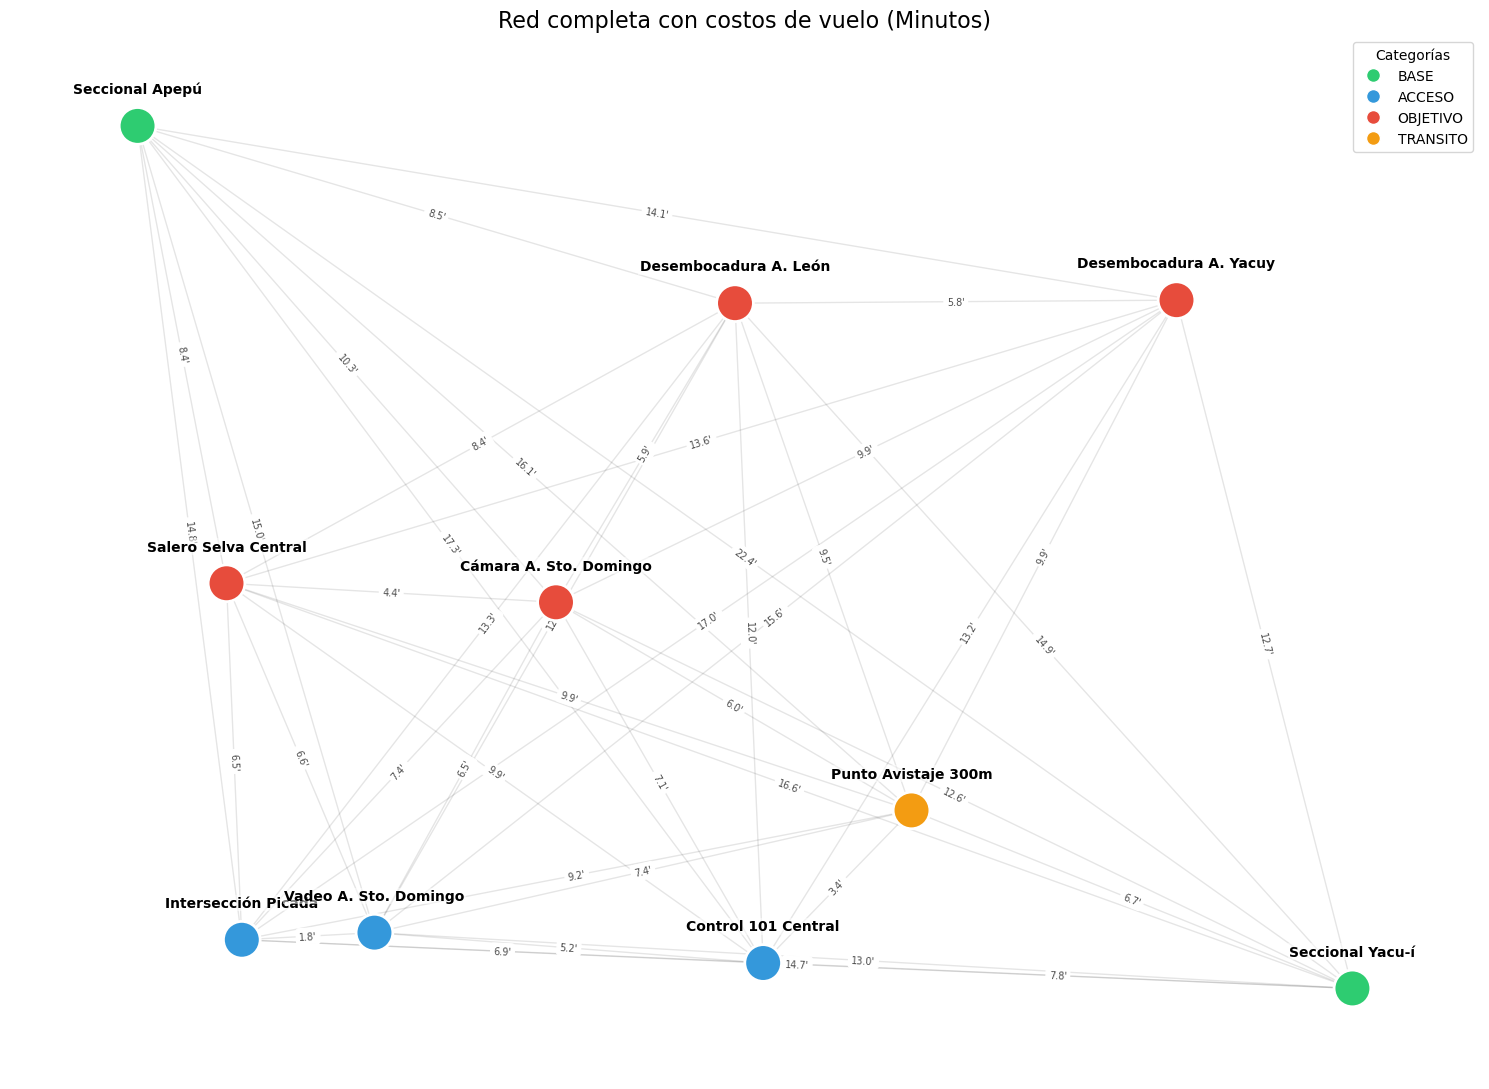

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

def visualizar_grafo_tecnico(df, matriz):
    G = nx.Graph()
    
    # 1. Definición de colores discretos por categoría
    color_map_dict = {
        'BASE': '#2ecc71',      # Verde
        'ACCESO': '#3498db',    # Azul
        'OBJETIVO': '#e74c3c',  # Rojo
        'TRANSITO': '#f39c12'   # Naranja
    }
    
    # 2. Añadir nodos
    for i, row in df.iterrows():
        G.add_node(i, pos=(row['lon'], row['lat']), 
                  color=color_map_dict.get(row['tag'], 'gray'),
                  nombre=row['nombre'])
    
    # 3. Añadir todas las aristas con su peso (Tiempo)
    # Nota: Mostraremos solo una dirección para no duplicar etiquetas en el gráfico
    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            G.add_edge(i, j, weight=matriz[i][j])

    pos = nx.get_node_attributes(G, 'pos')
    node_colors = [G.nodes[i]['color'] for i in G.nodes]
    
    plt.figure(figsize=(15, 11))
    
    # 4. Dibujar aristas con transparencia baja para evitar el "efecto telaraña"
    nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='black')
    
    # 5. Dibujar etiquetas de las aristas (Costo en minutos)
    # Filtramos para mostrar solo algunas o usamos un tamaño de fuente pequeño
    edge_labels = nx.get_edge_attributes(G, 'weight')
    edge_labels = {k: f"{v:.1f}'" for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, alpha=0.7)
    
    # 6. Dibujar Nodos
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors, 
                           edgecolors='white', linewidths=2)
    
    # 7. Etiquetas de nombres con offset mejorado
    # Desplazamos la etiqueta un poco más en latitud para que no toque el nodo
    label_pos = {k: (v[0], v[1] + 0.005) for k, v in pos.items()}
    nx.draw_networkx_labels(G, label_pos, {i: row['nombre'] for i, row in df.iterrows()}, 
                           font_size=10, font_weight='bold', 
                           bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=1))
    
    # Leyenda
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=k,
                              markerfacecolor=v, markersize=10) for k, v in color_map_dict.items()]
    plt.legend(handles=legend_elements, loc='best', title="Categorías")

    plt.title("Red completa con costos de vuelo (Minutos)", fontsize=16)
    plt.axis('off') # Eliminamos los ejes y el grid por completo
    plt.tight_layout()
    plt.show()

visualizar_grafo_tecnico(df_nodos, matriz_tiempos)

## 5. El Enfoque Tradicional: Problema del Viajante (TSP)

En una estrategia de vigilancia convencional, el objetivo inicial suele ser la **cobertura total**: visitar todos los puntos de interés en una sola misión para asegurar que no se ha pasado nada por alto. 

Matemáticamente, esto se conoce como el **Traveling Salesperson Problem (TSP)**. Buscamos encontrar el ciclo hamiltoniano de peso mínimo:

$$\min \sum_{i=0}^{n} \sum_{j=0}^{n} C_{ij} \cdot x_{ij}$$

Sujeto a que cada nodo sea visitado exactamente una vez y el dron regrese a la **Seccional Apepú (Nodo 0)**.

In [20]:
import itertools

def resolver_tsp_bruto(matriz, inicio=0):
    n = len(matriz)
    nodos_a_visitar = [i for i in range(n) if i != inicio]
    
    mejor_ruta = None
    menor_tiempo = float('inf')
    
    # Probamos todas las combinaciones posibles (9! = 362,880)
    # Es computacionalmente viable para 10 nodos
    for permutacion in itertools.permutations(nodos_a_visitar):
        ruta_actual = [inicio] + list(permutacion) + [inicio]
        tiempo_actual = 0
        
        for i in range(len(ruta_actual) - 1):
            tiempo_actual += matriz[ruta_actual[i]][ruta_actual[i+1]]
            
        if tiempo_actual < menor_tiempo:
            menor_tiempo = tiempo_actual
            mejor_ruta = ruta_actual
            
    return mejor_ruta, menor_tiempo

# Ejecutamos la búsqueda de la ruta óptima total
ruta_tsp, tiempo_tsp = resolver_tsp_bruto(matriz_tiempos, inicio=0)

print(f"--- RESULTADO ESTRATEGIA TSP ---")
print(f"Ruta óptima completa: {' -> '.join(df_nodos.loc[ruta_tsp, 'nombre'])}")
print(f"Tiempo mínimo necesario: {tiempo_tsp:.2f} minutos")
print(f"Límite de batería: 40.00 minutos")

--- RESULTADO ESTRATEGIA TSP ---
Ruta óptima completa: Seccional Apepú -> Salero Selva Central -> Cámara A. Sto. Domingo -> Intersección Picada -> Vadeo A. Sto. Domingo -> Control 101 Central -> Punto Avistaje 300m -> Seccional Yacu-í -> Desembocadura A. Yacuy -> Desembocadura A. León -> Seccional Apepú
Tiempo mínimo necesario: 64.22 minutos
Límite de batería: 40.00 minutos


### 5.1 Diagnóstico: El Límite de la Autonomía

Al calcular la ruta más corta que cubre el 100% de los nodos, observamos que el tiempo total es de **64 minutos**. 

**Conclusión técnica:**
Dado que la autonomía del dron es de **40 minutos**, la estrategia de cobertura total es **físicamente infactible**. Intentar esta ruta resultaría en la pérdida del equipo en la selva aproximadamente 24 minutos antes de completar el retorno. 

Este "fracaso" del modelo tradicional justifica la necesidad de pasar de un modelo de **cobertura total** a un modelo de **cobertura selectiva basada en valor**.

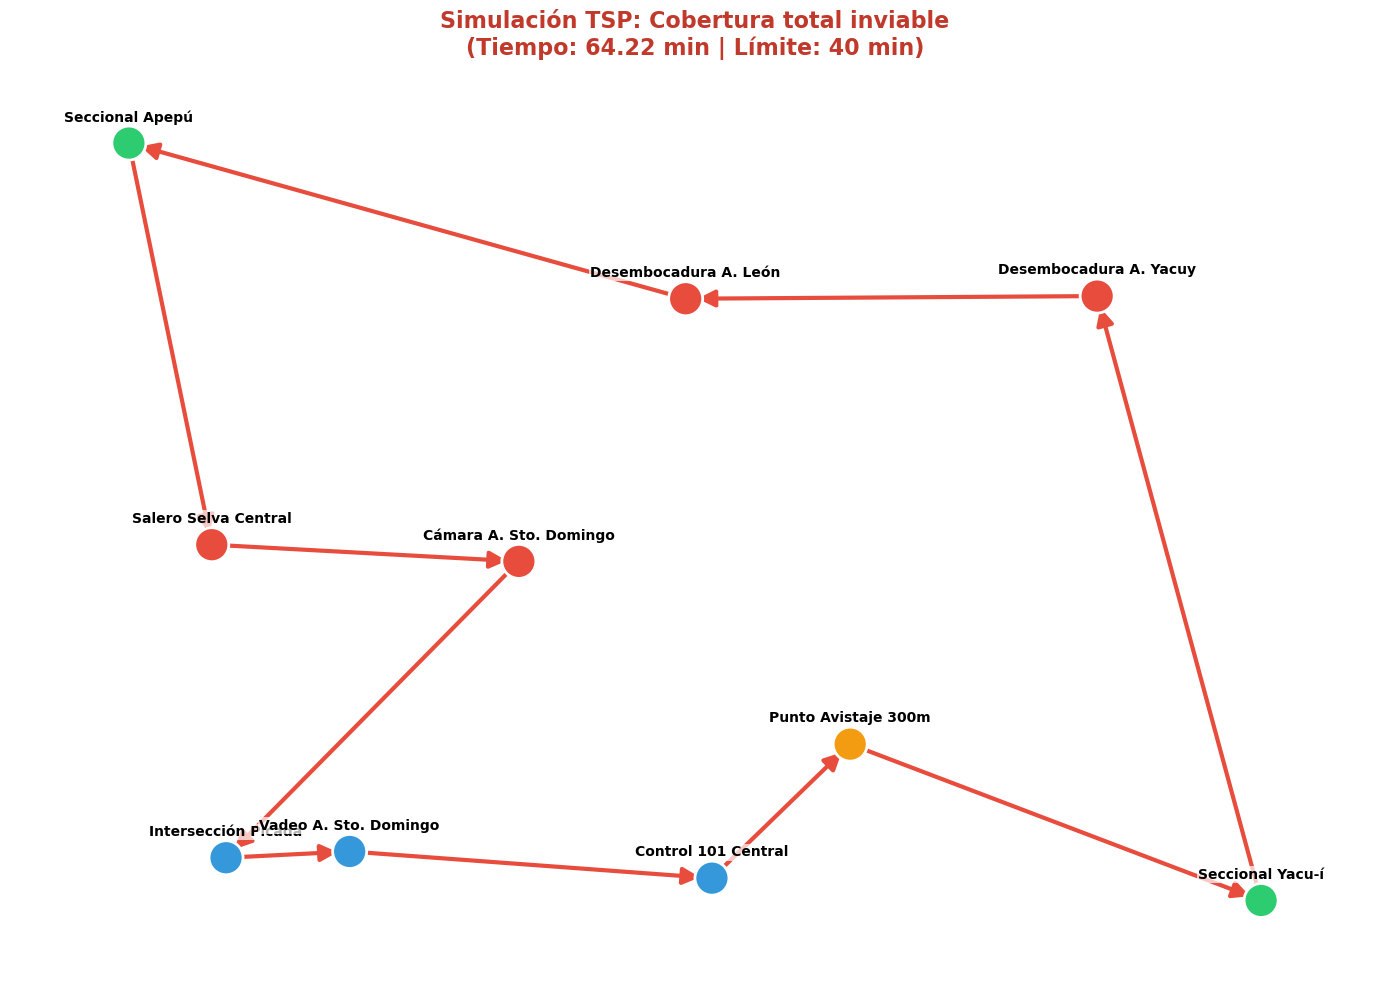

In [21]:
import networkx as nx
import matplotlib.pyplot as plt

def visualizar_ruta_tsp_final(df, ruta, titulo):
    # 1. Usamos DiGraph para permitir flechas (Dirección)
    G_plot = nx.DiGraph()
    
    # 2. Mapa de colores discretos (el mismo que usamos antes)
    color_map_dict = {
        'BASE': '#2ecc71',
        'ACCESO': '#3498db',
        'OBJETIVO': '#e74c3c',
        'TRANSITO': '#f39c12'
    }
    
    for i, row in df.iterrows():
        G_plot.add_node(i, pos=(row['lon'], row['lat']), 
                        color=color_map_dict.get(row['tag'], 'gray'))
    
    plt.figure(figsize=(14, 10))
    pos = nx.get_node_attributes(G_plot, 'pos')
    node_colors = [G_plot.nodes[i]['color'] for i in G_plot.nodes]
    
    # 3. Dibujar nodos con sus colores originales
    nx.draw_networkx_nodes(G_plot, pos, node_size=600, node_color=node_colors, edgecolors='white', linewidths=2)
    
    # 4. Dibujar etiquetas con offset
    label_pos = {k: (v[0], v[1] + 0.004) for k, v in pos.items()}
    nx.draw_networkx_labels(G_plot, label_pos, {i: r['nombre'] for i, r in df.iterrows()}, 
                           font_size=10, font_weight='bold',
                           bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    # 5. Dibujar la ruta con flechas (arrows=True y arrowstyle corrigen el Warning)
    edges_ruta = [(ruta[i], ruta[i+1]) for i in range(len(ruta)-1)]
    nx.draw_networkx_edges(G_plot, pos, edgelist=edges_ruta, 
                           edge_color='#e74c3c', width=3, 
                           arrows=True, arrowstyle='-|>', arrowsize=25)
    
    plt.title(titulo, fontsize=16, color='#c0392b', fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Ejecutamos la visualización final del TSP
visualizar_ruta_tsp_final(df_nodos, ruta_tsp, 
                         f"Simulación TSP: Cobertura total inviable\n(Tiempo: {tiempo_tsp:.2f} min | Límite: 40 min)")

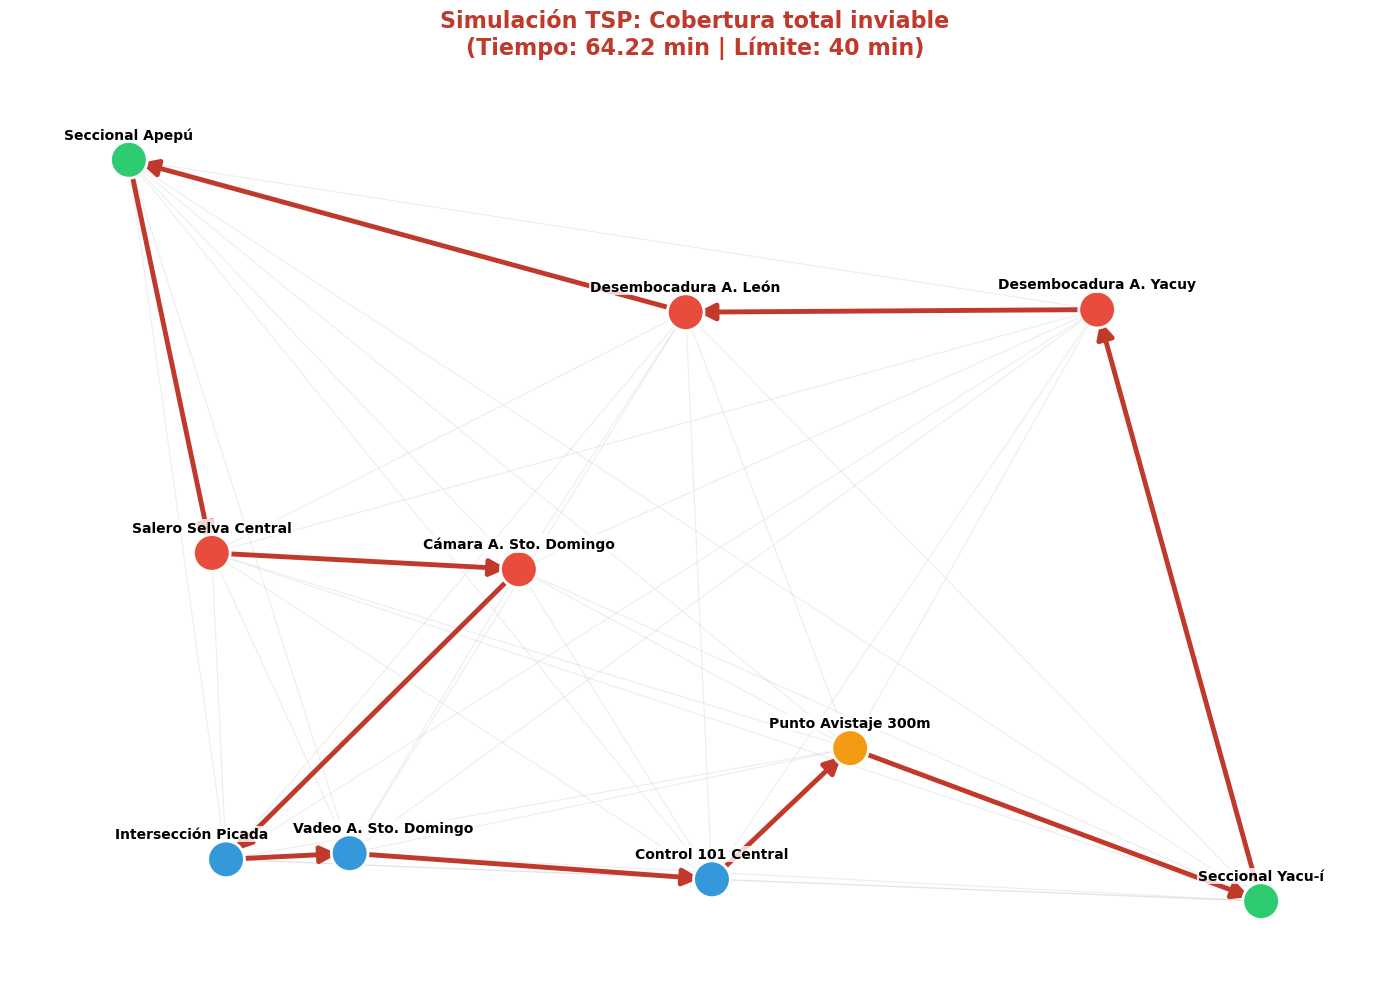

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

def visualizar_ruta_tsp_con_contexto(df, ruta, titulo):
    # 1. Configuración inicial del Grafo
    G_plot = nx.DiGraph()
    
    # 2. Mapa de colores (Tu paleta original)
    color_map_dict = {
        'BASE': '#2ecc71',
        'ACCESO': '#3498db',
        'OBJETIVO': '#e74c3c', # Acepta ambos tags por si acaso
        'HOTSPOT': '#e74c3c',
        'TRANSITO': '#f39c12'
    }
    
    # Agregar nodos al grafo
    for i, row in df.iterrows():
        color_nodo = color_map_dict.get(row['tag'], 'gray')
        G_plot.add_node(i, pos=(row['lon'], row['lat']), color=color_nodo)
    
    # Obtener posiciones
    pos = nx.get_node_attributes(G_plot, 'pos')
    
    plt.figure(figsize=(14, 10))
    
    # --- NUEVO: CAPA DE CONTEXTO (El "Fantasma" del Grafo Completo) ---
    # Generamos todas las combinaciones posibles de pares de nodos
    # Esto dibuja la "telaraña" gris de fondo
    todos_los_pares = list(combinations(df.index, 2))
    
    nx.draw_networkx_edges(
        G_plot, pos, 
        edgelist=todos_los_pares,
        edge_color='lightgray', 
        width=0.8, 
        alpha=0.4,  # Transparencia para que no moleste
        arrows=False # Sin flechas en el fondo
    )
    # ---------------------------------------------------------------
    
    # 3. Dibujar nodos (Encima de las líneas grises)
    node_colors = [G_plot.nodes[i]['color'] for i in G_plot.nodes]
    nx.draw_networkx_nodes(G_plot, pos, node_size=700, node_color=node_colors, edgecolors='white', linewidths=2)
    
    # 4. Dibujar la RUTA TSP (La línea roja protagonista)
    edges_ruta = [(ruta[i], ruta[i+1]) for i in range(len(ruta)-1)]
    
    nx.draw_networkx_edges(
        G_plot, pos, 
        edgelist=edges_ruta, 
        edge_color='#c0392b', # Rojo un poco más oscuro para contraste
        width=3.5, 
        alpha=1.0,
        arrows=True, 
        arrowstyle='-|>', 
        arrowsize=25
    )
    
    # 5. Dibujar etiquetas con tu offset original
    label_pos = {k: (v[0], v[1] + 0.004) for k, v in pos.items()}
    idx_izq = 6  # <-- ¡CAMBIA ESTO POR TU ÍNDICE REAL!
    if idx_izq in pos:
         # Restamos a X (izquierda), Restamos un poco a Y (abajo de la posición estándar)
        label_pos[idx_izq] = (pos[idx_izq][0]-0.004 , pos[idx_izq][1]+0.004)

    # Nodo de la derecha ("Vadeo..."): Lo movemos un poco a la DERECHA y ARRIBA
    idx_der = 8 
    if idx_der in pos:
        # Sumamos a X (derecha), Sumamos más a Y (más arriba)
        label_pos[idx_der] = (pos[idx_der][0]+0.004 , pos[idx_der][1]+0.004)
    # ---------------------------
    nx.draw_networkx_labels(
        G_plot, label_pos, 
        {i: r['nombre'] for i, r in df.iterrows()}, 
        font_size=10, 
        font_weight='bold',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=1)
    )
    
    # Título y ajustes finales
    plt.title(titulo, fontsize=16, color='#c0392b', fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    
    # Guardar automáticamente en la carpeta output
    plt.savefig("../outputs/grafo_tsp_contexto_fallido.png", dpi=300, bbox_inches='tight')
    plt.show()

# --- EJECUCIÓN ---
# Asegúrate de tener calculada la variable 'tiempo_tsp' antes de correr esto
titulo_grafico = f"Simulación TSP: Cobertura total inviable\n(Tiempo: {tiempo_tsp:.2f} min | Límite: 40 min)"

visualizar_ruta_tsp_con_contexto(df_nodos, ruta_tsp, titulo_grafico)

In [24]:
print(df_nodos[['nombre']])
# Busca los números de índice a la izquierda de:
# "Intersección Picada" y "Vadeo A. Sto. Domingo"

                   nombre
0         Seccional Apepú
1        Seccional Yacu-í
2     Control 101 Central
3   Desembocadura A. León
4    Salero Selva Central
5  Desembocadura A. Yacuy
6     Intersección Picada
7     Punto Avistaje 300m
8   Vadeo A. Sto. Domingo
9  Cámara A. Sto. Domingo



## 6. Conclusiones del Caso de Estudio - Parte 1

En esta primera fase del proyecto, hemos establecido los cimientos geoespaciales y físicos para la vigilancia del **Sector Apepú**:

1. **Modelado de Red:** Definimos 10 nodos estratégicos integrando infraestructura real y puntos de interés táctico.
2. **Restricción Física:** Implementamos la métrica de **Haversine** para calcular distancias reales, descubriendo que una misión circular completa (TSP) requiere aproximadamente **64 minutos**.
3. **El "Muro" Energético:** Con una autonomía de **40 minutos**, queda demostrado que el enfoque tradicional de "visitar todo" es inviable. El dron se agotaría antes de completar el retorno, resultando en la pérdida de la unidad.

### Próximos Pasos: Notebook 02
En la siguiente entrega, abandonaremos el paradigma de la cobertura total para abrazar la **Optimización Inteligente**. Desarrollaremos el algoritmo de **Orienteering Problem (OP)**, donde el objetivo no es recorrer todo el mapa, sino seleccionar los nodos que maximicen el valor de vigilancia dentro de la ventana de 40 minutos.

**¿Es mejor visitar 4 nodos de alto impacto o 7 de bajo valor?** Lo descubriremos en el próximo notebook.